# Time Series Analysis
1. Import libraries and data
2. Subsetting, wrangling and cleaning
3. Decomposition
4. Test time series for stationarity
5. Make time series stationary

# 1. Import libraries and data

In [1]:
# Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

In [3]:
# Disable deprecation warnings
warnings.filterwarnings("ignore")

In [5]:
# Adjust styling of plots
plt.style.use('fivethirtyeight')

In [6]:
# Configure API key 
quandl.ApiConfig.api_key = 'FQRynR-4ANsyRKpTc4f3'

In [7]:
# Import data set: US historical real home price index (Yale Dept. of Economics)
data = quandl.get('YALE/RHPI')

In [8]:
data.head()

,Index
Date,
1890-12-31,100.000000
1891-12-31,88.011791
1892-12-31,95.421736
1893-12-31,92.297385
1894-12-31,123.980483


In [9]:
data.shape

(885, 1)

In [11]:
data.tail()

,Index
Date,
2021-02-28,196.651559
2021-03-31,200.454390
2021-04-30,205.242307
2021-05-31,209.720987
2021-06-30,213.387258


In [12]:
data.columns

Index(['Index'], dtype='object')

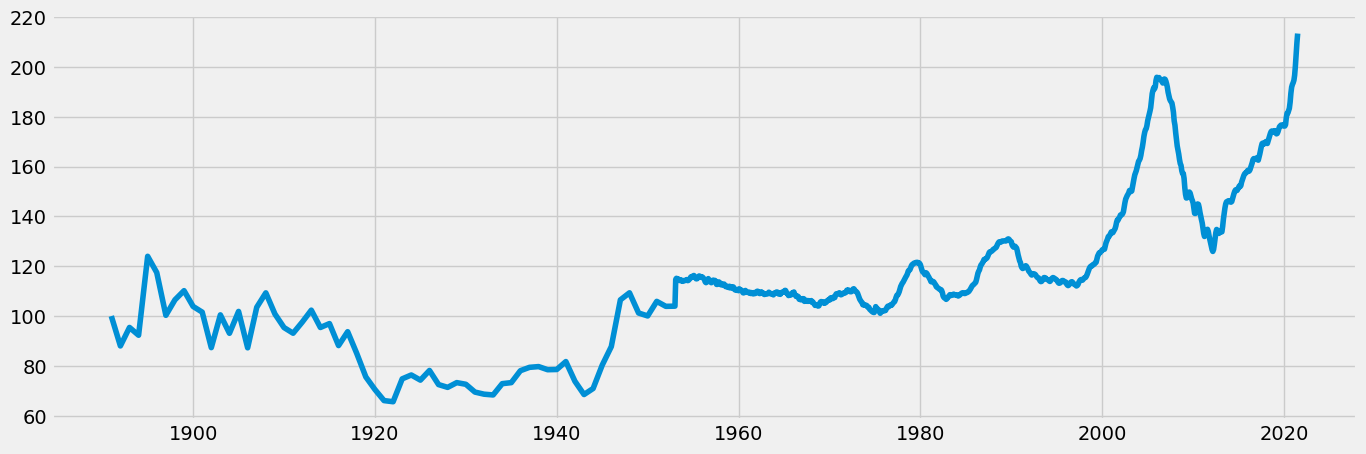

In [13]:
# Plot data with reduced DPI
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

In [14]:
# Check type
type(data)

pandas.core.frame.DataFrame

# 2. Subsetting, wrangling and cleaning

In [15]:
# Create subset and add index 
data_2 = data.reset_index()

In [16]:
data_2.head()

,Date,Index
0,1890-12-31,100.000000
1,1891-12-31,88.011791
2,1892-12-31,95.421736
3,1893-12-31,92.297385
4,1894-12-31,123.980483


In [17]:
# Create subset for records from 1990 to 2021
data_3 = data_2.loc[(data_2['Date'] >= '1990-01-01')]

I selected data starting from 1990 as this year marks the beginning of important political changes affecting the economy, until now. 

In [18]:
data_3.head()

,Date,Index
507,1990-01-31,128.529886
508,1990-02-28,128.027702
509,1990-03-31,127.668860
510,1990-04-30,127.884108
511,1990-05-31,128.014447


In [19]:
data_3.shape

(378, 2)

In [21]:
# Make Date index again, for that import datetime
from datetime import datetime

data_3['datetime'] = pd.to_datetime(data_3['Date'])
data_3 = data_3.set_index('datetime')
data_3.drop(['Date'], axis=1, inplace=True)

In [22]:
data_3.head()

,Index
datetime,
1990-01-31,128.529886
1990-02-28,128.027702
1990-03-31,127.668860
1990-04-30,127.884108
1990-05-31,128.014447


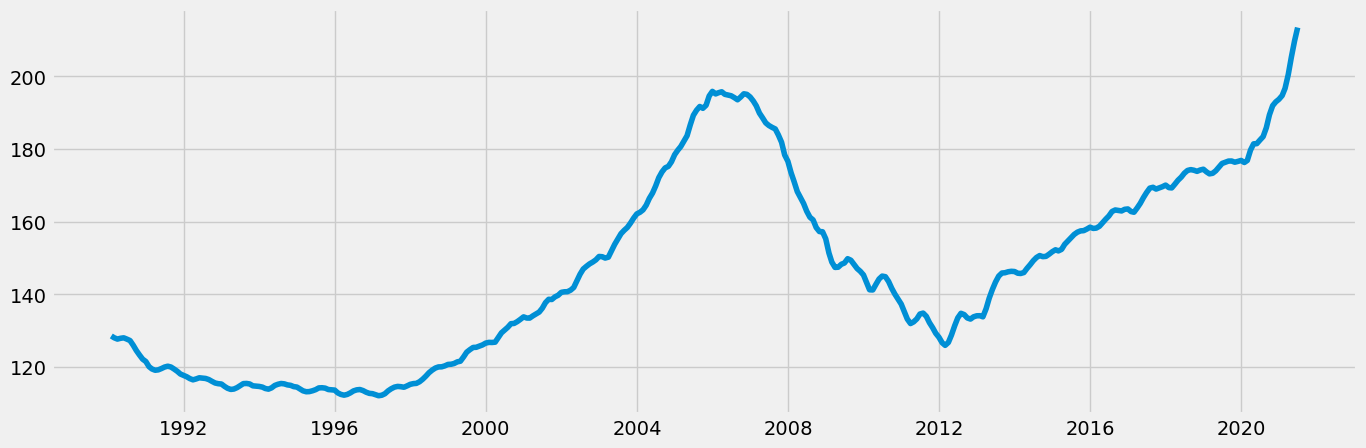

In [23]:
# Plot it
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_3)

This time series is nonlinear and has a trend, seasonality and arguably a cycle.

In [24]:
# Check missing values
data_3.isnull().sum() 

Index    0
dtype: int64

In [25]:
# Check for duplicates
dups = data_3.duplicated()
dups.sum()

0

There are no missing values nor duplicates. 

# 3. Decomposition

In [27]:
# Decompose it with an multiplicative model 
decomposition = sm.tsa.seasonal_decompose(data_3, model='multiplicative')

In [28]:
# Define fixed size for special charts, import rcParams
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

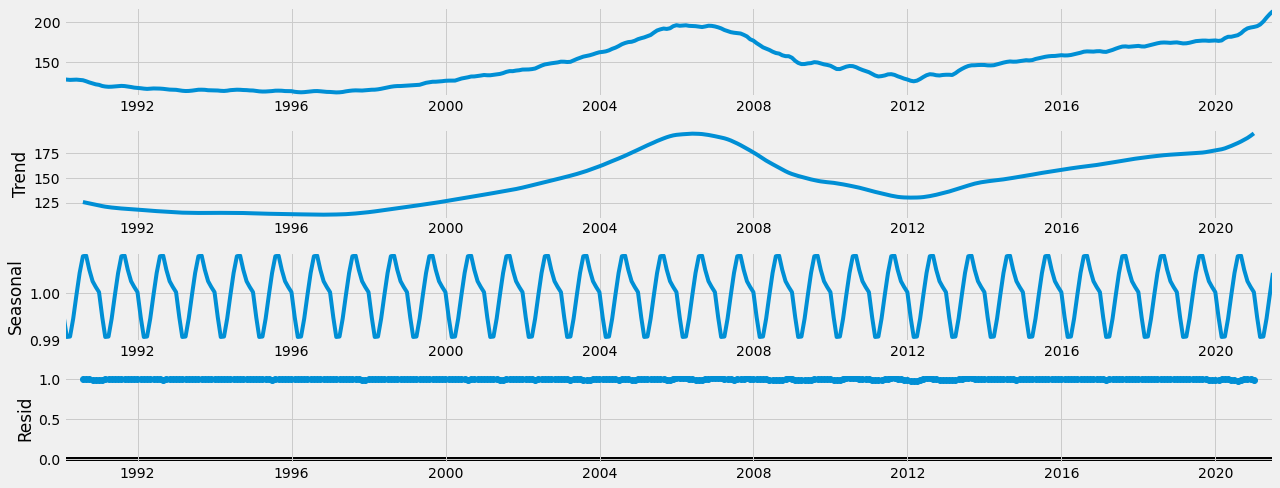

In [29]:
# Plot the decomposition
decomposition.plot()
plt.show()

The decomposition shows a overall (dominant) upward trend with a peak in 2006-7. 

It shows the time series has seasonality and very low noise. 

The trend and seasonality imply the series is non-stationary. Now I will test this. 

# 4. Test time series for stationarity

H0: The time series has a unit root, is non-stationary.  

HA: The time series has no unit root, is stationary. 

In [30]:
# Import adfuller, define function which prints correct output (number array)
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [31]:
# Apply test using function on time series
dickey_fuller(data_3['Index'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.094657
p-value                          0.965694
Number of Lags Used             17.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64


The test statistic is larger than all critical values.

I cannot reject the null hypothesis. 

The time series has a unit root and is therefore non-stationary and has a p-value of 0.97. 

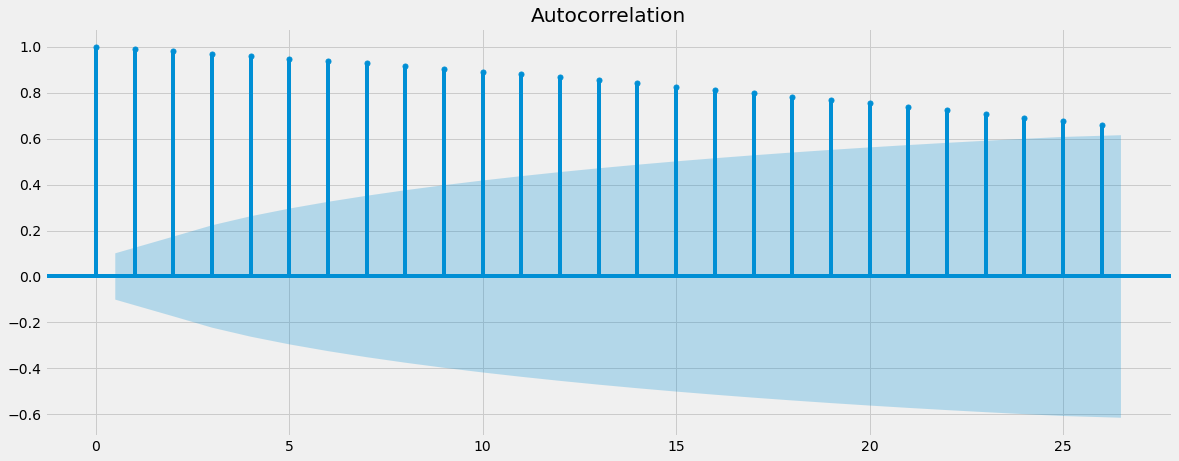

In [32]:
# Check for autocorrelations, import autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_3)
plt.show()

There are many lags significantly correlated to each other, which also points towards a non-stationary data set. 

# 5. Make time series stationary


In [33]:
# Create subset applying the differencing method
data_diff = data_3 - data_3.shift(1)

In [34]:
# Remove the resulting missing values
data_diff.dropna(inplace = True) 

In [35]:
# Have a look
data_diff.head()

,Index
datetime,
1990-02-28,-0.502184
1990-03-31,-0.358841
1990-04-30,0.215248
1990-05-31,0.130339
1990-06-30,-0.348866


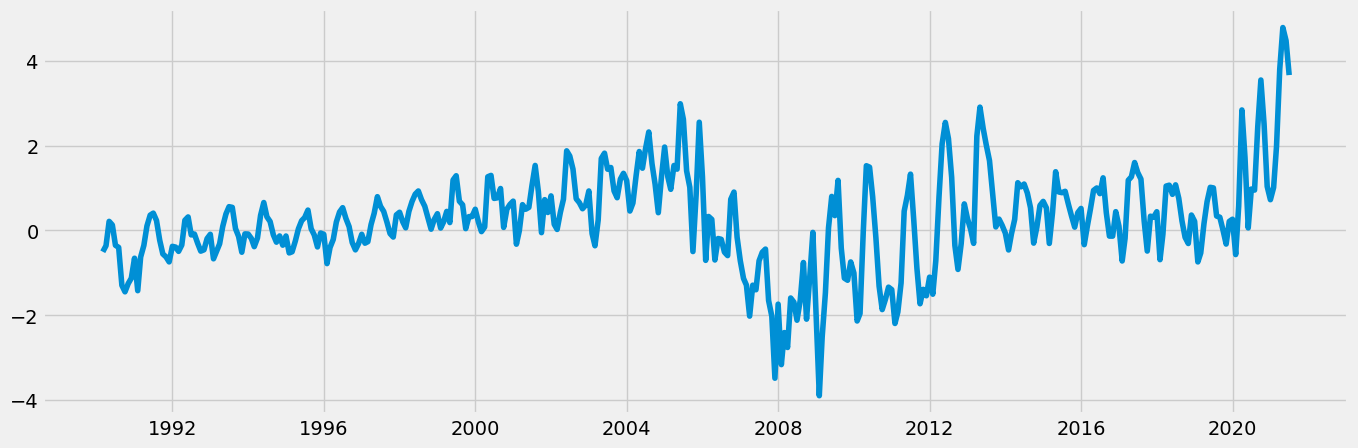

In [36]:
# Check how does the differencing changed the the graph
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [37]:
# Perform Dickey-Fuller on data_diff
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.085271
p-value                          0.250478
Number of Lags Used             17.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


It looks better but I still can't reject the null hypothesis. 

In [38]:
# Do a 2nd round of differencing
data_diff_2 = data_diff - data_diff.shift(1)

In [39]:
data_diff_2.dropna(inplace = True) 

In [40]:
data_diff_2.head()

,Index
datetime,
1990-03-31,0.143343
1990-04-30,0.574090
1990-05-31,-0.084909
1990-06-30,-0.479205
1990-07-31,-0.050400


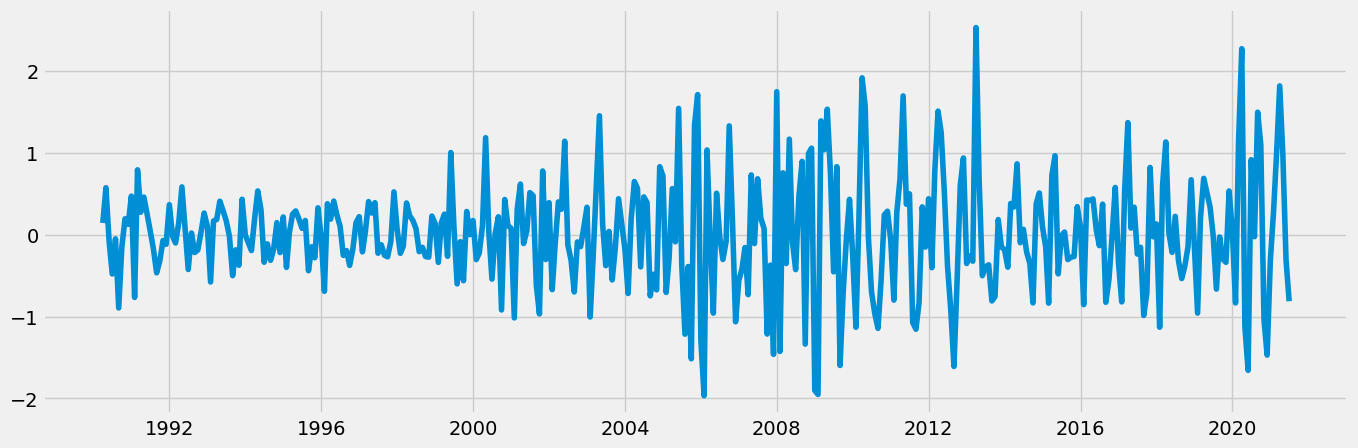

In [41]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [42]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.720604
p-value                          0.070540
Number of Lags Used             16.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


The test statistic is now slightly larger than the 5% and 1% critical values at a more satisfactory though not perfect p-value of 0.07. 

I can now reject the null hypothesis. The data can now be considered stationary. 

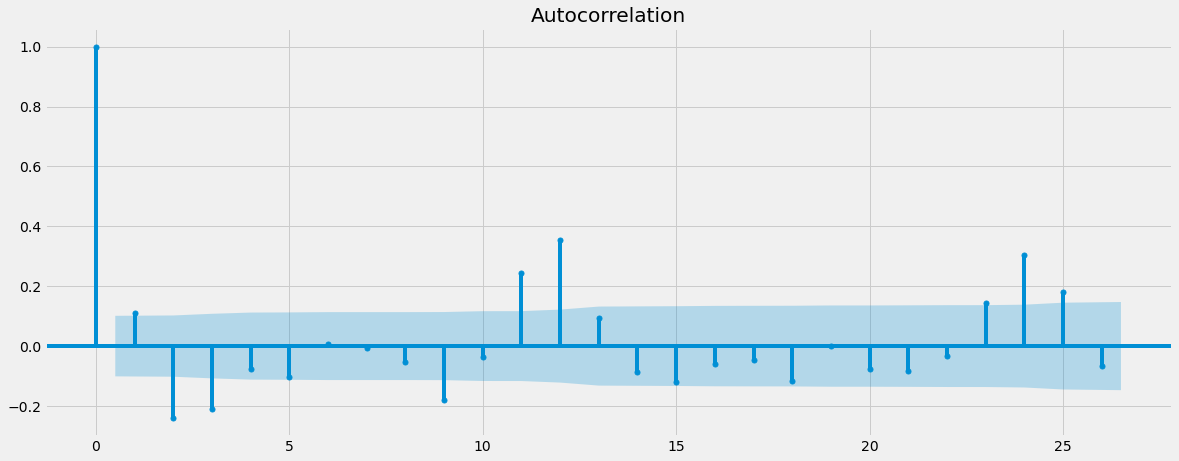

In [43]:
# Check autocorrelations after differencing
plot_acf(data_diff_2)
plt.show()

The number of lags with high autocorrelation has decreased, though there remain some. 

I could do another round of differencing but I might overdifference the data. 